<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_acquisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install import_ipynb
import import_ipynb

In [2]:
!wget https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/defs_common.ipynb -O "defs_common.ipynb"
from defs_common import *

--2020-01-02 10:57:27--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/defs_common.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4764 (4.7K) [text/plain]
Saving to: ‘defs_common.ipynb’

defs_common.ipynb   100%[===================>]   4.65K  --.-KB/s    in 0s      

2020-01-02 10:57:27 (62.9 MB/s) - ‘defs_common.ipynb’ saved [4764/4764]

importing Jupyter notebook from defs_common.ipynb


In [0]:
import os
import re
from skimage import io
import cv2 as cv
import pandas as pd

# Introduction

Our goal is to solve a Sudoku puzzle which is contained within an image (or stream of images).
Thus, first of all, we have to acquire some images to be analyzed.
Because we want to train and evaluate different classifiers later on, we also provide the digits that are shown within each image.

Because of the large amount of data we are acquiring, we resize each input image to a fixed size upon import.
Otherwise the data would not fit into RAM and we would have to use some sort of generator that dynamically loads information from the disk.
We have to keep in mind, that the resolution defined by `input_image_size` is going to be crucial for the quality of our analysis.

In [0]:
input_image_size = (512, 512)

We are using two datasets: One that we have found on the internet and another one we have built ourselves.

# Publicly available Sudoku dataset

This dataset is freely available as a [GitHub repository](https://github.com/wichtounet/sudoku_dataset). We are using the "train" subset containing roughly 160 images labelled with the respective digits. The images were taken using different cameras. No handwritten digits are included.

## Download

First we have to download the dataset from GitHub for which we are using the `wget` command.

In [5]:
!wget https://github.com/wichtounet/sudoku_dataset/blob/master/datasets/v2_train.tar.bz2?raw=true -O "v2_train.tar.bz2"

--2020-01-02 10:57:29--  https://github.com/wichtounet/sudoku_dataset/blob/master/datasets/v2_train.tar.bz2?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wichtounet/sudoku_dataset/raw/master/datasets/v2_train.tar.bz2 [following]
--2020-01-02 10:57:29--  https://github.com/wichtounet/sudoku_dataset/raw/master/datasets/v2_train.tar.bz2
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wichtounet/sudoku_dataset/master/datasets/v2_train.tar.bz2 [following]
--2020-01-02 10:57:29--  https://raw.githubusercontent.com/wichtounet/sudoku_dataset/master/datasets/v2_train.tar.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

## Extraction

Then we extract the downloaded archive using the `tar` command.

In [6]:
!tar xvfj "v2_train.tar.bz2"

v2_train/image1.jpg
v2_train/image10.jpg
v2_train/image100.jpg
v2_train/image1000.jpg
v2_train/image1001.jpg
v2_train/image1003.jpg
v2_train/image1004.jpg
v2_train/image1006.jpg
v2_train/image1007.jpg
v2_train/image1008.jpg
v2_train/image101.jpg
v2_train/image1011.jpg
v2_train/image1014.jpg
v2_train/image1062.jpg
v2_train/image102.jpg
v2_train/image1020.jpg
v2_train/image1022.jpg
v2_train/image103.jpg
v2_train/image1031.jpg
v2_train/image1036.jpg
v2_train/image1038.jpg
v2_train/image1039.jpg
v2_train/image104.jpg
v2_train/image1040.jpg
v2_train/image1043.jpg
v2_train/image1045.jpg
v2_train/image1048.jpg
v2_train/image1049.jpg
v2_train/image105.jpg
v2_train/image1050.jpg
v2_train/image1055.jpg
v2_train/image1059.jpg
v2_train/image106.jpg
v2_train/image1066.jpg
v2_train/image1067.jpg
v2_train/image107.jpg
v2_train/image1070.jpg
v2_train/image1075.jpg
v2_train/image1076.jpg
v2_train/image1077.jpg
v2_train/image1078.jpg
v2_train/image1081.jpg
v2_train/image1082.jpg
v2_train/image1083.jpg
v

## Reading input image filenames

All images and their respective labels are now stored within the `./v2_train` directory. We iterate through all files within that directory using `os.listdir` and remember all files having a `.jpg` extension. Thereby we filter out all `.dat` files that contain the labels. These will be read in a following step.

In [7]:
input_image_filenames_pub = []
input_image_basedir = "v2_train"
for filename in os.listdir(input_image_basedir):
  if not filename.endswith(".jpg"):
    continue
  filename = os.path.join(input_image_basedir, filename)
  input_image_filenames_pub.append(filename)
  print("Discovered input image", filename)

Discovered input image v2_train/image143.jpg
Discovered input image v2_train/image1077.jpg
Discovered input image v2_train/image82.jpg
Discovered input image v2_train/image1083.jpg
Discovered input image v2_train/image1081.jpg
Discovered input image v2_train/image209.jpg
Discovered input image v2_train/image169.jpg
Discovered input image v2_train/image118.jpg
Discovered input image v2_train/image42.jpg
Discovered input image v2_train/image150.jpg
Discovered input image v2_train/image160.jpg
Discovered input image v2_train/image84.jpg
Discovered input image v2_train/image201.jpg
Discovered input image v2_train/image191.jpg
Discovered input image v2_train/image195.jpg
Discovered input image v2_train/image26.jpg
Discovered input image v2_train/image102.jpg
Discovered input image v2_train/image11.jpg
Discovered input image v2_train/image33.jpg
Discovered input image v2_train/image164.jpg
Discovered input image v2_train/image163.jpg
Discovered input image v2_train/image1082.jpg
Discovered i

## Reading input image data

Using `skimage.io.imread` we then load all images given by the filenames we have previously discovered. 

In [8]:
input_image_data_pub = []
for filename in input_image_filenames_pub:
  data = io.imread(filename)
  data = cv.resize(data, input_image_size)
  input_image_data_pub.append(data)
  print("Read input image", filename)

Read input image v2_train/image143.jpg
Read input image v2_train/image1077.jpg
Read input image v2_train/image82.jpg
Read input image v2_train/image1083.jpg
Read input image v2_train/image1081.jpg
Read input image v2_train/image209.jpg
Read input image v2_train/image169.jpg
Read input image v2_train/image118.jpg
Read input image v2_train/image42.jpg
Read input image v2_train/image150.jpg
Read input image v2_train/image160.jpg
Read input image v2_train/image84.jpg
Read input image v2_train/image201.jpg
Read input image v2_train/image191.jpg
Read input image v2_train/image195.jpg
Read input image v2_train/image26.jpg
Read input image v2_train/image102.jpg
Read input image v2_train/image11.jpg
Read input image v2_train/image33.jpg
Read input image v2_train/image164.jpg
Read input image v2_train/image163.jpg
Read input image v2_train/image1082.jpg
Read input image v2_train/image115.jpg
Read input image v2_train/image180.jpg
Read input image v2_train/image1000.jpg
Read input image v2_train/

### Visualization

For demonstration purposes the images are then displayed using the **matplotlib** library.

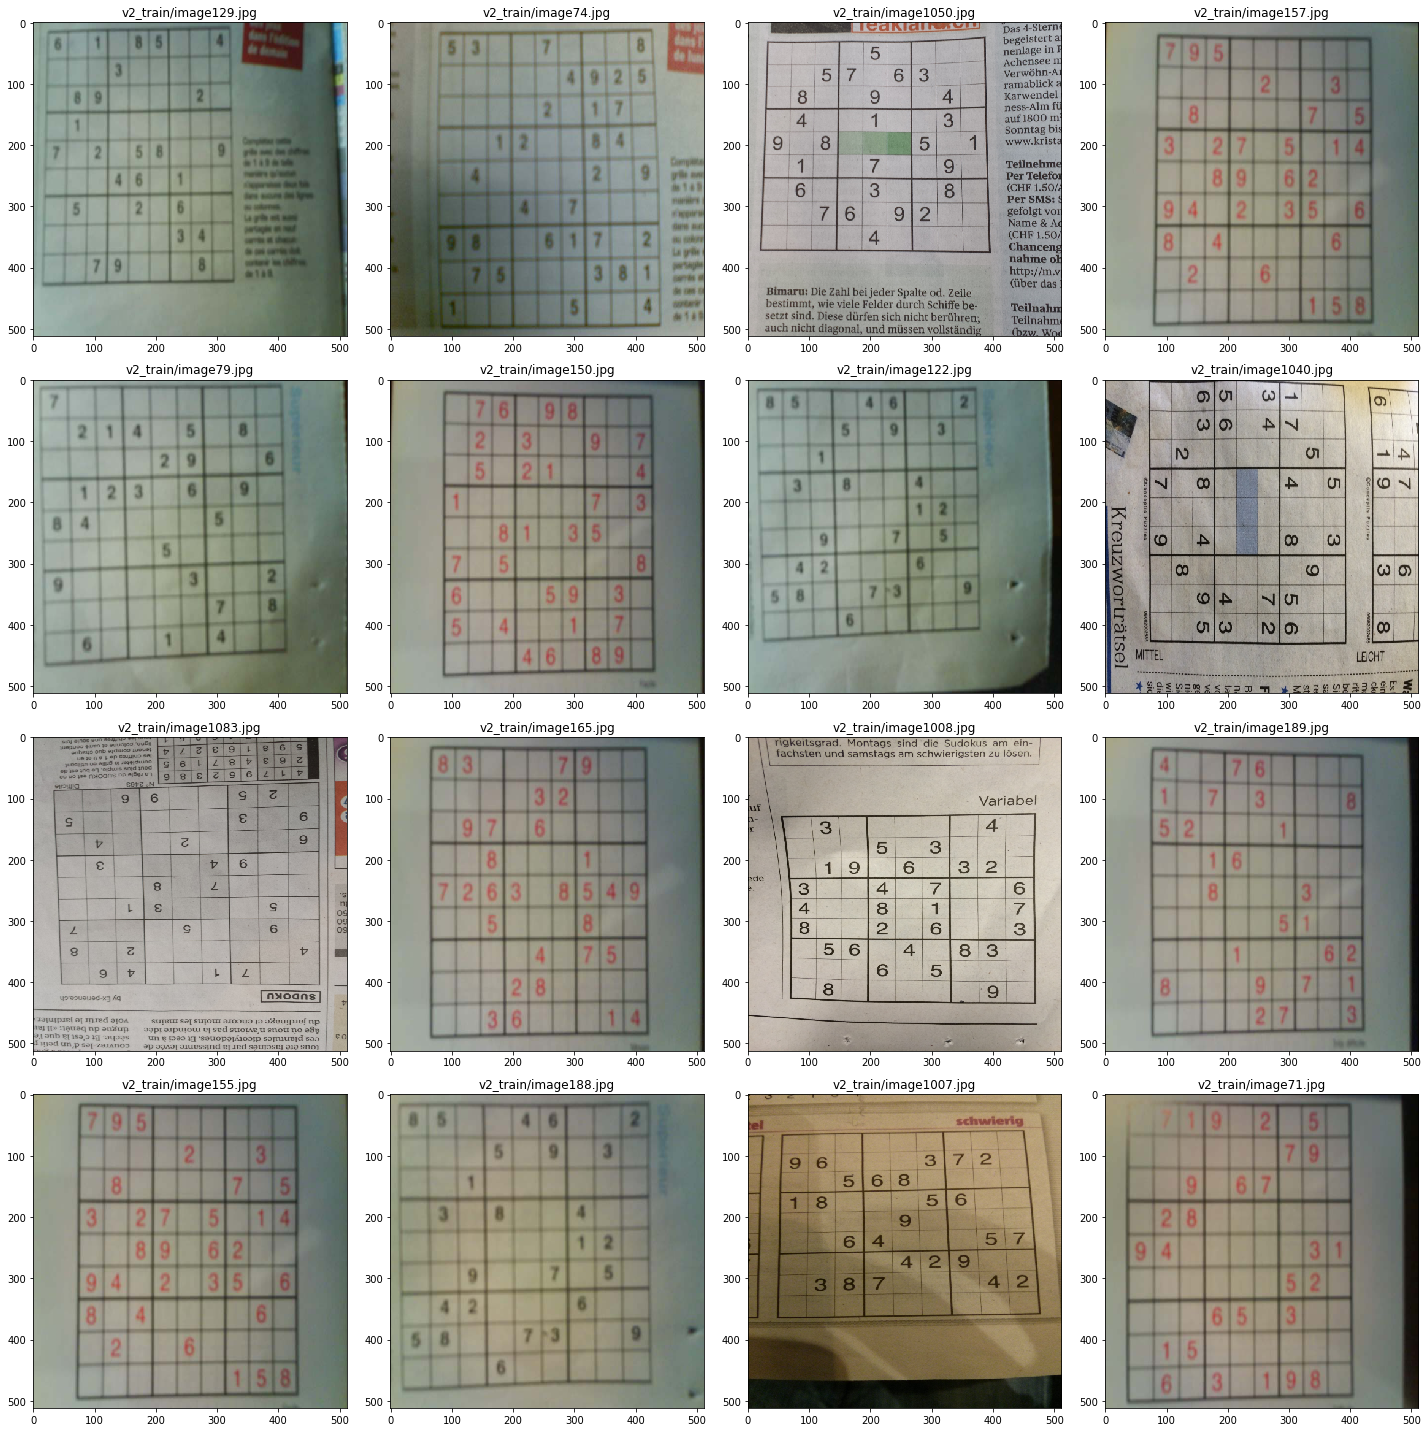

In [9]:
show_images(input_image_data_pub, titles=input_image_filenames_pub, n_samples=16)

## Reading input image labels

The labels for each image are stored within a file having the same base name as the image but ending with `.dat`. The first line states the camera that has been used to capture the image. The second line contains the X and Y resolution, bit depth and file type. The next 9 lines then contain the actual digits delimited by spaces and line breaks.

For example `image1.dat` looks like this:

```
sonyEricsson s500i
640x480:24 JPG
0 0 0 7 0 0 0 8 0 
0 9 0 0 0 3 1 0 0 
0 0 6 8 0 5 0 7 0 
0 2 0 6 0 0 0 4 9 
0 0 0 2 0 0 0 5 0 
0 0 8 0 4 0 0 0 7 
0 0 0 9 0 0 0 3 0 
3 7 0 0 0 0 0 0 6 
1 0 5 0 0 4 0 0 0
```

We wrote a simple parser that discards the first two lines containing meta data and then parses the digits line wise.

In [10]:
input_image_digits_pub = []
for filename in input_image_filenames_pub:
  # replace jpg extension with dat
  filename = filename[:-4] + ".dat"
  print("Reading digits from", filename)
  with open(filename, "r") as file:
    lines = file.readlines()
    rows = []
    # skip first two lines
    for line in lines[2:]:
      digits = re.findall("\d", line)
      digits = [int(x) for x in digits]
      assert len(digits) == 9
      rows.append(digits)
    assert len(rows) == 9
    input_image_digits_pub.append(rows)

Reading digits from v2_train/image143.dat
Reading digits from v2_train/image1077.dat
Reading digits from v2_train/image82.dat
Reading digits from v2_train/image1083.dat
Reading digits from v2_train/image1081.dat
Reading digits from v2_train/image209.dat
Reading digits from v2_train/image169.dat
Reading digits from v2_train/image118.dat
Reading digits from v2_train/image42.dat
Reading digits from v2_train/image150.dat
Reading digits from v2_train/image160.dat
Reading digits from v2_train/image84.dat
Reading digits from v2_train/image201.dat
Reading digits from v2_train/image191.dat
Reading digits from v2_train/image195.dat
Reading digits from v2_train/image26.dat
Reading digits from v2_train/image102.dat
Reading digits from v2_train/image11.dat
Reading digits from v2_train/image33.dat
Reading digits from v2_train/image164.dat
Reading digits from v2_train/image163.dat
Reading digits from v2_train/image1082.dat
Reading digits from v2_train/image115.dat
Reading digits from v2_train/image18

The element `input_image_digits[i][j][k]` contains the digit of the cell in the `i`-th image located in the `j`-th row and `k`-th column.
Empty cells contain the number `0` which never occurs in a Sudoku puzzle.

### Visualization

The grid data structure for a specific image can be visualized using the method `print_grid` which prints the non-zero digits in the console.

In [11]:
print_grid(input_image_digits_pub[0])

-------------------------------------
|   | 7 | 1 | 9 |   | 2 |   | 5 |   |
-------------------------------------
|   |   |   |   |   |   | 7 | 9 |   |
-------------------------------------
|   |   | 9 |   | 6 | 7 |   |   |   |
-------------------------------------
|   | 2 | 8 |   |   |   |   |   |   |
-------------------------------------
| 9 | 4 |   |   |   |   |   | 3 | 1 |
-------------------------------------
|   |   |   |   |   |   | 5 | 2 |   |
-------------------------------------
|   |   |   | 6 | 5 |   | 3 |   |   |
-------------------------------------
|   | 1 | 5 |   |   |   |   |   |   |
-------------------------------------
|   | 6 |   | 3 |   | 1 | 9 | 8 |   |
-------------------------------------



# Custom Sudoku dataset

Our custom Sudoku dataset consists of a set of albums.
Each album contains images of exactly one Sudoku puzzle from different perspectives and different lighting conditions.
Within each album there is also a file called `digits.txt` that lists the actual digits visible in each image. 

### Download

Because of its large file size and restrictions of GitHub we store the dataset on Google Drive.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset is then copied from Google Drive to the local storage.

In [0]:
!cp "./drive/My Drive/dataset.zip" "./dataset.zip"

### Extraction

There the archive contents are extracted.

In [14]:
!unzip -o "./dataset.zip"

Archive:  ./dataset.zip
  inflating: dataset/000000701/digits.txt  
  inflating: dataset/000000701/IMG_8767.JPG  
  inflating: dataset/000000701/IMG_8768.JPG  
  inflating: dataset/000000701/IMG_8769.JPG  
  inflating: dataset/000000701/IMG_8770.JPG  
  inflating: dataset/000000701/IMG_8771.JPG  
  inflating: dataset/000000701/IMG_8772.JPG  
  inflating: dataset/000000701/IMG_8773.JPG  
  inflating: dataset/000000701/IMG_8774.JPG  
  inflating: dataset/000000701/IMG_8775.JPG  
  inflating: dataset/000000701/IMG_8776.JPG  
  inflating: dataset/000000701/IMG_8778.JPG  
  inflating: dataset/000000701/IMG_8779.JPG  
  inflating: dataset/000000701/IMG_8780.JPG  
  inflating: dataset/000000701/IMG_8781.JPG  
  inflating: dataset/000000701/IMG_8782.JPG  
  inflating: dataset/000000701/IMG_8783.JPG  
  inflating: dataset/000000701/IMG_8784.JPG  
  inflating: dataset/000000701/IMG_8785.JPG  
  inflating: dataset/000000701/IMG_8786.JPG  
  inflating: dataset/000000701/IMG_8787.JPG  
  inflating:

### Reading dataset

In [15]:
import re

def parse_digits_txt(lines):
  rows = []
  for line in lines:
    digits = re.findall("\d", line)
    digits = [int(x) for x in digits]
    rows.append(digits)
  return np.array(rows)

def read_digits_txt(filename):
  with open(filename, "r") as file:
    lines = file.readlines()
    return parse_digits_txt(lines)

input_image_filenames_custom = []
input_image_data_custom = []
input_image_digits_custom = []

basedir = "./dataset"
for album_name in os.listdir(basedir):
  album_path = os.path.join(basedir, album_name)
  print("Discovered album", album_path)
  digits_path = os.path.join(album_path, "digits.txt")
  print("Reading digits from", digits_path)
  digits = read_digits_txt(digits_path)
  print("Read", digits.shape, "digits")
  for image_name in os.listdir(album_path):
    if image_name.endswith(".txt"):
      continue # ignore txt files
    image_path = os.path.join(album_path, image_name)
    print("Discovered image", image_path)
    input_image_filenames_custom.append(image_path)
    input_image_digits_custom.append(digits)
    print("Reading image data from", image_path)
    image_data = io.imread(image_path)
    print("Read", image_data.shape, "pixels")
    image_data = cv.resize(image_data, input_image_size)
    input_image_data_custom.append(image_data)

Discovered album ./dataset/234598176
Reading digits from ./dataset/234598176/digits.txt
Read (9, 9) digits
Discovered image ./dataset/234598176/IMG_8877.JPG
Reading image data from ./dataset/234598176/IMG_8877.JPG
Read (4032, 3024, 3) pixels
Discovered image ./dataset/234598176/19-12-12 12-50-54 8949.jpg
Reading image data from ./dataset/234598176/19-12-12 12-50-54 8949.jpg
Read (4032, 3024, 3) pixels
Discovered image ./dataset/234598176/IMG_8881.JPG
Reading image data from ./dataset/234598176/IMG_8881.JPG
Read (4032, 3024, 3) pixels
Discovered image ./dataset/234598176/IMG_8878.JPG
Reading image data from ./dataset/234598176/IMG_8878.JPG
Read (4032, 3024, 3) pixels
Discovered image ./dataset/234598176/19-12-12 12-50-57 8950.jpg
Reading image data from ./dataset/234598176/19-12-12 12-50-57 8950.jpg
Read (4032, 3024, 3) pixels
Discovered image ./dataset/234598176/19-12-12 12-50-47 8946.jpg
Reading image data from ./dataset/234598176/19-12-12 12-50-47 8946.jpg
Read (4032, 3024, 3) pixels

## Visualization

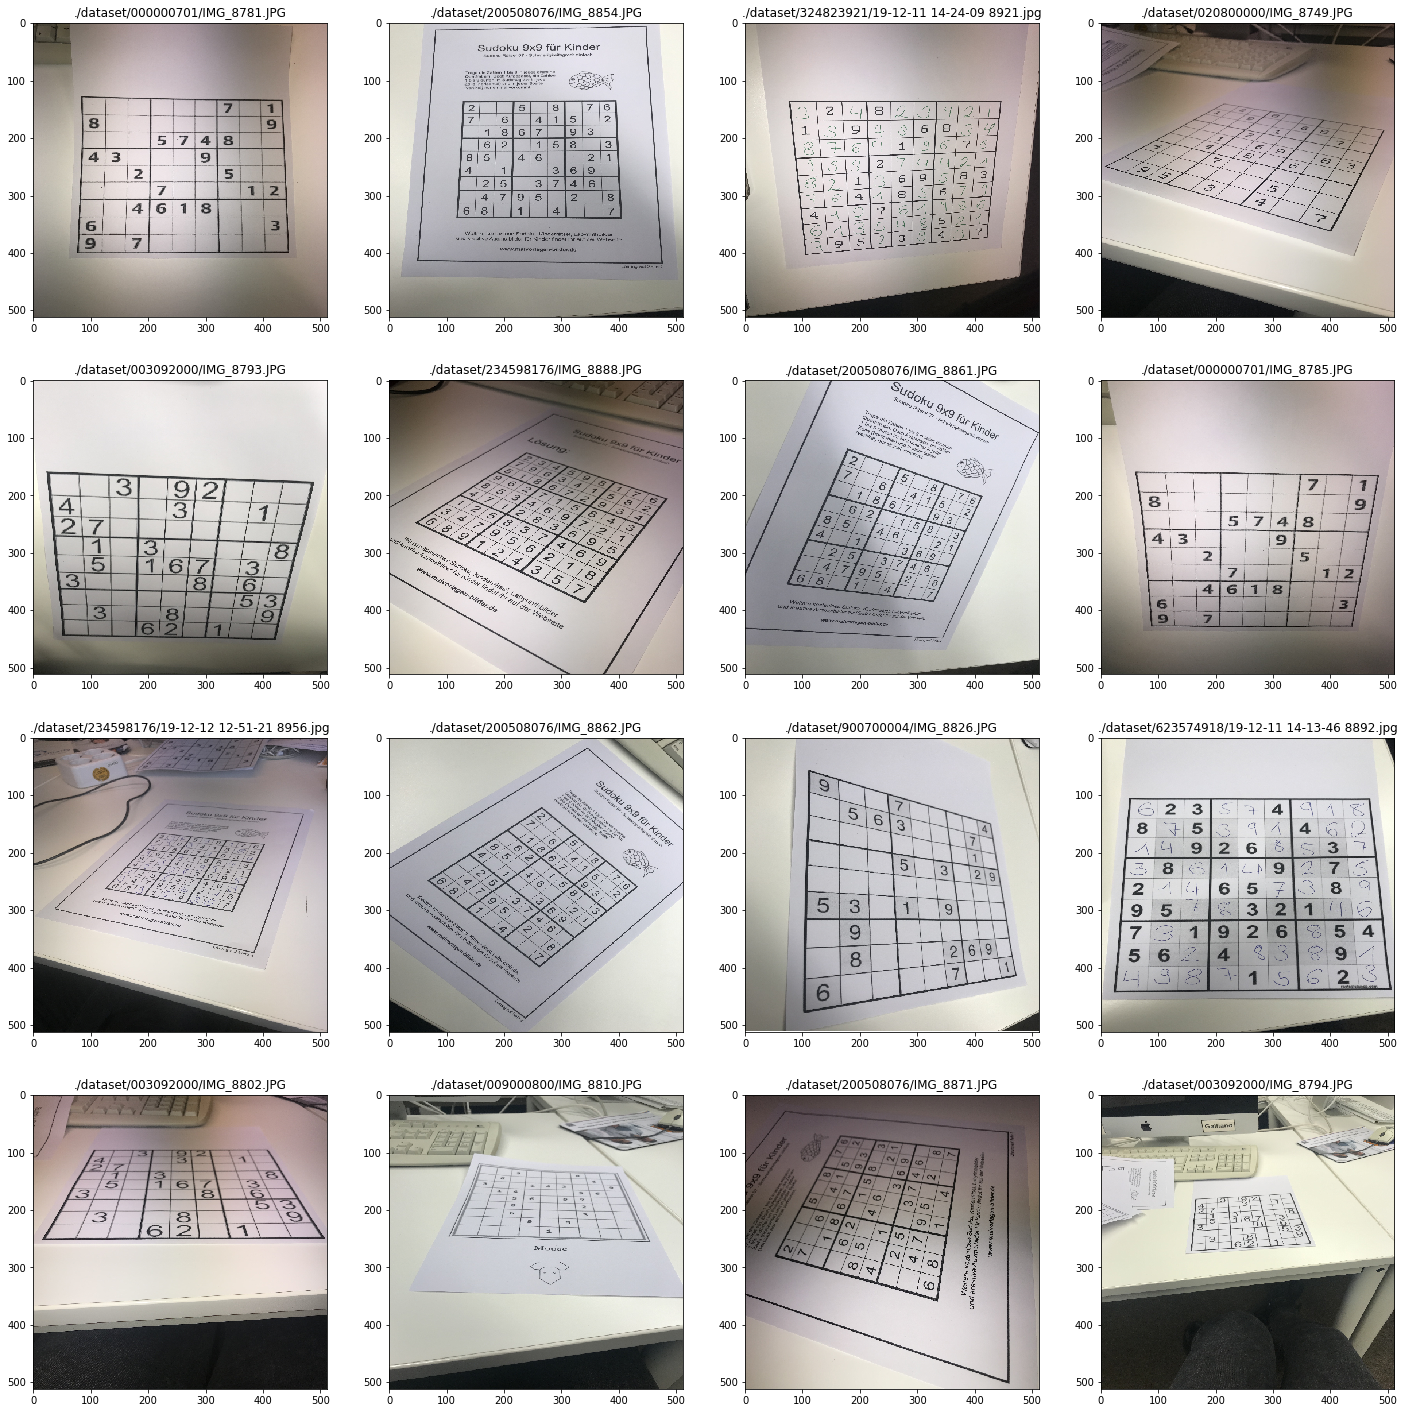

In [45]:
show_images(input_image_data_custom, input_image_filenames_custom, n_samples=16)

# Merging the datasets

In [0]:
input_images = pd.DataFrame({
    "filename": input_image_filenames_pub + input_image_filenames_custom,
    "data": input_image_data_pub + input_image_data_custom,
    "digits": input_image_digits_pub + input_image_digits_custom
})

In [48]:
input_images

filename  ...                                             digits
0               v2_train/image143.jpg  ...  [[0, 7, 1, 9, 0, 2, 0, 5, 0], [0, 0, 0, 0, 0, ...
1              v2_train/image1077.jpg  ...  [[0, 7, 1, 0, 0, 0, 2, 0, 0], [0, 0, 0, 6, 8, ...
2                v2_train/image82.jpg  ...  [[0, 0, 0, 0, 0, 9, 0, 0, 0], [2, 0, 0, 0, 8, ...
3              v2_train/image1083.jpg  ...  [[0, 0, 7, 1, 0, 0, 4, 6, 0], [4, 0, 0, 0, 0, ...
4              v2_train/image1081.jpg  ...  [[0, 0, 6, 0, 0, 2, 0, 3, 0], [0, 8, 0, 0, 5, ...
..                                ...  ...                                                ...
351  ./dataset/000000701/IMG_8782.JPG  ...  [[0, 0, 0, 0, 0, 0, 7, 0, 1], [8, 0, 0, 0, 0, ...
352  ./dataset/000000701/IMG_8769.JPG  ...  [[0, 0, 0, 0, 0, 0, 7, 0, 1], [8, 0, 0, 0, 0, ...
353  ./dataset/000000701/IMG_8768.JPG  ...  [[0, 0, 0, 0, 0, 0, 7, 0, 1], [8, 0, 0, 0, 0, ...
354  ./dataset/000000701/IMG_8772.JPG  ...  [[0, 0, 0, 0, 0, 0, 7, 0, 1], [8, 0, 0, 0, 0, ...
355  ./dataset/000000701/IMG_8771.JPG  ...  [[0, 0, 0, 0, 0, 0, 7, 0, 1], [8, 0, 0, 0, 0, ...

[356 rows x 3 columns]

# Export

In [0]:
input_images.to_pickle("sudoku_dataset_dataframe.bz2")

In [0]:
!cp "./sudoku_dataset_dataframe.bz2" "./drive/My Drive/sudoku_dataset_dataframe.bz2"